# Final project of CS6840

## Install some basic library

In [88]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba install -c conda-forge rdkit
!pip install torch-geometric

In [ ]:
import torch
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

import rdkit
import statistics 
import math
from torch_geometric.datasets import MoleculeNet

## Download ESOL dataset and explore the dataset

In [91]:
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")

In [92]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


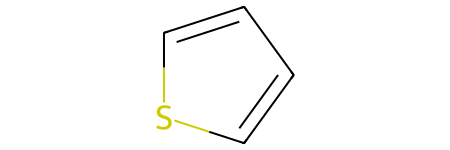

In [93]:
# Explore the molecular structure
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[4]["smiles"])
molecule

## Define GNN

In [94]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


## Training 

In [95]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=256, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665949821472168
Epoch 100 | Train Loss 0.8540144562721252
Epoch 200 | Train Loss 1.1124600172042847
Epoch 300 | Train Loss 0.32616838812828064
Epoch 400 | Train Loss 0.23733144998550415
Epoch 500 | Train Loss 0.38460591435432434
Epoch 600 | Train Loss 0.21460913121700287
Epoch 700 | Train Loss 0.07613381743431091
Epoch 800 | Train Loss 0.16954778134822845
Epoch 900 | Train Loss 0.1719018965959549
Epoch 1000 | Train Loss 0.04264683648943901
Epoch 1100 | Train Loss 0.06374474614858627
Epoch 1200 | Train Loss 0.11927658319473267
Epoch 1300 | Train Loss 0.05650372430682182
Epoch 1400 | Train Loss 0.0292583629488945
Epoch 1500 | Train Loss 0.06205352768301964
Epoch 1600 | Train Loss 0.032278869301080704
Epoch 1700 | Train Loss 0.016336504369974136
Epoch 1800 | Train Loss 0.04432741925120354
Epoch 1900 | Train Loss 0.0358462929725647


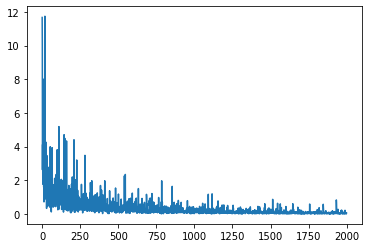

In [96]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

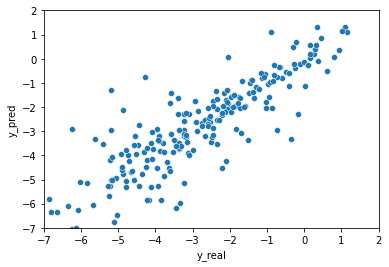

In [97]:
import pandas as pd 

test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=256, shuffle=False)

# Analyze the results for the whole testing dataset
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [98]:
# Evaluation metric: Correlation coefficient(R^2), average absolute error(AAE) and standard deviation
# Correlation coefficient(R^2)
r_2 = r2_score(list(df["y_real"]), list(df["y_pred"]))
print("In testing dataset: GNN:r2 = {}".format(r_2))

# Average absolute error(AAE)
aae = sum(abs(df["y_real"] - df["y_pred"])) / len(df["y_real"])
print("In testing dataset: GNN: aae = {}".format(aae))

std = statistics.stdev(list(df["y_pred"]))
print("In testing dataset: GNN：se = {}".format(std / math.sqrt(std)))

In testing dataset: GNN:r2 = 0.7710042457445009
In testing dataset: GNN: aae = 0.6604861833435376
In testing dataset: GNN：se = 1.4405038757816089


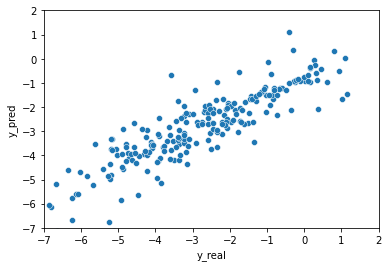

In [99]:
from sklearn.metrics import r2_score

# Baseline: ESOL
df_ESOL = pd.DataFrame()
df = pd.read_csv("/content/esol/raw/delaney-processed.csv")
df_ESOL["y_real"] = df["measured log solubility in mols per litre"]
df_ESOL["y_pred"] = df["ESOL predicted log solubility in mols per litre"]

df = pd.DataFrame()
df["y_real"] = df_ESOL["y_real"].iloc[902:]
df["y_pred"] = df_ESOL["y_pred"].iloc[902:]

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [100]:
# Evaluation metric: Correlation coefficient(R^2), average absolute error(AAE) and standard deviation
# Correlation coefficient(R^2)
r_2 = r2_score(list(df["y_real"]), list(df["y_pred"]))
print("In testing dataset: ESOL:r2 = {}".format(r_2))

# Average absolute error(AAE)
aae = sum(abs(df["y_real"] - df["y_pred"])) / len(df["y_real"])
print("In testing dataset: ESOL: aae = {}".format(aae))

std = statistics.stdev(list(df["y_pred"]))
print("In testing dataset: ESOL：se = {}".format(std / math.sqrt(std)))

In testing dataset: ESOL:r2 = 0.7839834529021221
In testing dataset: ESOL: aae = 0.7403274336283189
In testing dataset: ESOL：se = 1.2912999118658077
